# Experiment 2
---------------
Test 2: Custom transfer learning model freezing Inception V3

Reshape data

In [6]:
%run ./prepare_dataset.ipynb

System version
 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]

Your Device List:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11280467363552761281
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6700198133
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17276579516891793104
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [7]:
img_width, img_height, img_size, batch_size =  prepareConstants(299 ,299,299,16)
train_data_dir, validation_data_dir = setDirs()
train_generator, validation_generator = prepareDatasets(train_data_dir,validation_data_dir,img_width,img_height,batch_size)
checkData(train_generator,validation_generator)


Image Width: 299
Image Height: 299
Image Size: 299
Batch Size: 16

Train dir: ../fruits-360/Training/
Test dir: ../fruits-360/Test/

Import Trainingset
Found 53177 images belonging to 103 classes.

Import Validationset
Found 17845 images belonging to 103 classes.

Train Samples:  53177
Train Classes: 103
Class Indexes:
 {'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Cactus fruit': 19, 'Cantaloupe 1': 20, 'Cantaloupe 2': 21, 'Carambula': 22, 'Cherry 1': 23, 'Cherry 2': 24, 'Cherry Rainier': 25, 'Cherry Wax Black': 26, 'Cherry Wax Red': 27, 'Cherry Wax Yellow': 28, 'Chestnut': 29, 'Clementine': 30, 'Cocos': 31, 'Dates': 32, 'Granadilla': 33,

(53177, 103, 17845, 103)

In [8]:
#import inception with pre-trained weights. do not include fully #connected layers
inception = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

Freeze Layers

In [9]:
# Freeze the layers except the last 4 layers
for layer in inception.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in inception.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000021C5F997780> False
<keras.layers.convolutional.Conv2D object at 0x0000021C5F997F60> False
<keras.layers.normalization.BatchNormalization object at 0x0000021C5F997978> False
<keras.layers.core.Activation object at 0x0000021C5F997A90> False
<keras.layers.convolutional.Conv2D object at 0x0000021C5F9D8F98> False
<keras.layers.normalization.BatchNormalization object at 0x0000021C5FA047F0> False
<keras.layers.core.Activation object at 0x0000021C5FE56F98> False
<keras.layers.convolutional.Conv2D object at 0x0000021C6008CF28> False
<keras.layers.normalization.BatchNormalization object at 0x0000021C60069A58> False
<keras.layers.core.Activation object at 0x0000021C60053AC8> False
<keras.layers.pooling.MaxPooling2D object at 0x0000021C60129940> False
<keras.layers.convolutional.Conv2D object at 0x0000021C60129B00> False
<keras.layers.normalization.BatchNormalization object at 0x0000021C60167908> False
<keras.layers.core.Activation object at 0x

Create and define the model

In [10]:
# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(inception)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))

classes=train_generator.num_classes
print("Number of classes:",classes)
model.add(layers.Dense(classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['acc'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Number of classes: 103
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              134218752 
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 103)               105575    
Total params: 156,127,111
Trainable params: 134,324,327
Non-trainable params: 21,802,784
_______________________________________________

### Train the model

In [11]:
start_time = time.time()

with tf.device("/device:GPU:0"):
    # Train the model
    history = model.fit_generator(
          train_generator,
          steps_per_epoch=train_generator.samples/train_generator.batch_size ,
          epochs=5,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples/validation_generator.batch_size,
          verbose=1)
 

print("\nTraining completed")
elapsed_time = time.time() - start_time
print("Time:",elapsed_time) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3324/3323 [==============================] - 1969s 592ms/step - loss: 1.0423 - acc: 0.7480 - val_loss: 2.9412 - val_acc: 0.3015
Epoch 2/5
3324/3323 [==============================] - 1465s 441ms/step - loss: 0.2013 - acc: 0.9457 - val_loss: 3.0142 - val_acc: 0.2981
Epoch 3/5
3324/3323 [==============================] - 1451s 436ms/step - loss: 0.1186 - acc: 0.9681 - val_loss: 2.7896 - val_acc: 0.3467
Epoch 4/5
3324/3323 [==============================] - 1457s 438ms/step - loss: 0.0876 - acc: 0.9775 - val_loss: 2.8132 - val_acc: 0.3344
Epoch 5/5
3324/3323 [==============================] - 1467s 441ms/step - loss: 0.0688 - acc: 0.9824 - val_loss: 2.6863 - val_acc: 0.3504

Training completed


See the results

In [12]:
print("Validation Accuracy max:",history.history['val_acc'][-1])
print("Validation Loss max:",history.history['val_loss'][-1])
print("Training Accuracy max:",history.history['acc'][-1])
print("Training Loss max:",history.history['loss'][-1])

Validation Accuracy max: 0.3503502381636202
Validation Loss max: 2.6863035547729965
Training Accuracy max: 0.9823796002030953
Training Loss max: 0.06881602044664113


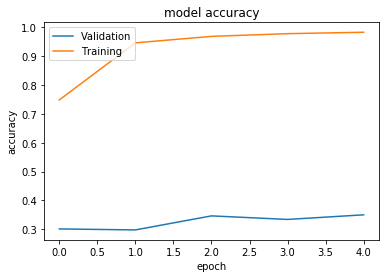

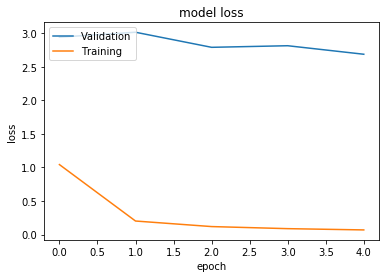

In [13]:
# summarize history for accuracy
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Validation','Training'],loc = 'upper left')
plt.savefig('../plots/exp2_p2_acc.png')
plt.show()


# summarize history for loss
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Validation','Training'],loc = 'upper left')
plt.savefig('../plots/exp2_p2_loss.png')
plt.show()


In [14]:
saveKerasModel(model,"inceptionV3Freeze")

Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
Impossibile to serialize the model, please check the code and retry


False

In [15]:
errors = seeErrors(validation_data_dir,validation_generator,model)

1116/1115 [==============================] - 92s 83ms/step
No of errors = 17656/17845
Errors not printed
